# WORKSHOP 2

------------

**<u>GRUPO 4<u>**

Digital House

link git hub: https://github.com/grupo4dhds/grupo4_git.git

--------------
## ACLARACIONES

**Cambio en la convensión de Dicto[keys], a partir de ahora la posición [0] (*) se utiliza para el dicionario main y el resto de indices para datas auxiliares**
    
**Creacion de Dicture = {}: no tiene filtro, todos los modelos que se entren para uso general o uso predictorio tienen que aparecer dentro de este set**
    
**Creacion de Model = {}: este diccionario contiene unicamente los modelos predictorios**
    
**Dicto['models']: no es para analizar dicho modelo, sino para comparar los features y los parámetros estimados ENTRE modelos, para analisis del modelo dirigirse a Dicture**
    
**Dicto['models']: caso excepcional con posición única (*)**
    
    
## ACLARACIONES 2
    
**Dicto almacena diccionarios de dataframes, la llave models tiene la expeción de tener una posicion/etiquéta unica, por lo tanto se almacena en formato tipo DataFrame**
    
**Dicture: almacena 3 dataframes, y 2 arrays por matriz feature creada; por convención al crearse una llave todas las posiciones de la tupla deben completarse, para aquellas que no estén, no existan ni vayan a existir se designa con 0, y aquellas que vayan a estar se designa 1**

**Model: Solo aquellos modelos entrenados, que hayan pasado por la instancia 5, fit, entran en esta categoría, revisar disparidades con Dicture**
    
**Dicture: La principal diferencia entre una llave Dicture que se encuentra dentro de Model y una que no, es que Dicture en Model incluye valores de performance (* *), y Dicture que no esté en model un string con los hiperparámetros de la instanciacion**
    
**Dicture: identificar los performance (* *) que son en string como valores representativos del modelo, y los que están en otro tipo de variable son porque tiene utilidad como hiperparámetro de otro modelo**    
    
**Dicture: la longitud de la tupla puede variar en funcion de las performance que se convierten en hiperparámetros de las que no**    
    
## CONTENIDO
    
    **IMPORTANTE: frenarse en las celda 28 para explicar un poco la estructura de datos**

After cell 12:
    
    Dicto.keys(): (actualizar)
        - data_cruda
        - surface_nan
        - data
        - dummy_place

Celda 12:
    
    * implementación del modelo machine learning

Celda 12-13:    
    
    * creacion Dicture[linreg] = X, y, linreg.intercept_, linreg.coef_, y_pred_train
    * creacion: Dicto[models] = data_models 
    * creacion Model[linreg] = linreg, Dicto[models], Dicture[linreg]

(DESACTUALIZACION INDICE CELDAS)    

Celda 18:
    
    * prediccion del modelo sobre una muestra de datos extraídos de otra sección del dataset original
    
Celda 19: (mask_2 ask)
    
    * Chequeo de cuanto afecta considerar las labels categorizadas como "otros"

##Celda 21:
    
    * Recordar que esta muestra viene de otro criterio de seleccion, y por eso es necesario matchiar valores estadísticos que se calcularon sin ser estos elementos parte de la muestra

Celda 25:    
    
    * Guardado de la data: Dicto['muestra']
    
Celda 27:
    
    * Comprobación visual del rango de aplicacion del modelo: (aclaracion en parte 2 - After regularizacón)
    
Celda 29: 
    
    * Chequear esa celda que trabaja con un data_aux, no entiendo la complicación de empalme que podría estar sucediendo
    
Celda 31: 
    
    * grafico - visualizacion
    
... continua con regularizacion

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression

In [3]:
def lista_featurend(X, label_i):
    for i in range(len(X.columns)):
        if list(X.columns)[i] == label_i:
            lista_featur_end = (list(X.columns)[i:])
    return lista_featur_end
        
def cambia_nombre_columnas(data, **kwarg):
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html
    for key in kwarg.keys():
        data.rename(kwarg[key], axis=1, inplace=True)
    return data

def cambia_orden_columnas(check_list, data, safe=1): # safe: es para conservar la primera columna con indice[0]
    label_list = list(data.columns)
    for i in range(len(check_list)):
        label_list.remove(check_list[i])
        label_list.insert(i+safe, check_list[i])
        data = data.reindex(label_list, axis=1)
        
def data_info(data, name='data'):
    df = pd.DataFrame(pd.Series(data.columns))
    df.columns = ['columna']
    df.columns.name = f'df de {name}'
    df.index.name = 'index'
    df['Nan'] = data.isna().sum().values
    df['dtype']  = data.dtypes.values
    df['count'] = data.count().values
    df['pct_nan'] = round(df['Nan']/data.shape[0]*100,2)
    df['count_unique'] = [len(data[elemento].value_counts()) for elemento in data.columns]
    return df


def visualizacion_dos_scatter(frame1, frame2, x, y_1, y_2):
    x1 = frame1[x]
    x2 = frame2[x]
    y_real = frame1[y_1]
    y_pred = frame2[y_2]
    plt.scatter(x1, y_real)
    plt.scatter(x2, y_pred) # muestra, entonces com
    plt.suptitle('y, y_pred');
    
    
    ax = plt.axes() #instancia de un objeto
    # tiene atributos y tiene métodos
    # los atributos .algo y los métodos son .algo()
    # 
    ax.set(xlabel = 'x', ylabel='price')
    #azules reales
    #naranjas predichos
    

    """
dame dos datasets, ya filtrados

# separame el eje x, de cualquier de los dos datasets
# armame una serie de cada valor real/predicho
""";
def variables_feature(frame):
    frame['sup_total_pow2'] = frame.surface_total_in_m2 * frame.surface_total_in_m2
    frame['sup_descubierta'] = frame.surface_total_in_m2 - frame.surface_covered_in_m2
    frame['sup_descubierta_pct'] = frame.sup_descubierta / frame.surface_total_in_m2 *100
    frame = frame.drop('sup_descubierta', axis=1)
    return frame

def analisis_nans(frame):
    df = data_info(frame)
    lista_not_na = list((df[df.Nan == 0].columna).values)
    lista_con_na = list((df[df.Nan != 0].columna).values)
    
    print ('ANALISIS DE NANS')
    print (frame[lista_con_na].isna().sum().to_string())
    #print ('La suma es {}'.format(3198+746))
    print ('Cantidad de elemento: {}'.format(frame[lista_con_na].shape[0]))
    print ('Interseccion entre los nan encuentra: {} elementos'.format(frame[lista_con_na].isna().all(axis=1).sum()))
    print('Union entre los nan encuentra: {} elementos'.format(frame[lista_con_na].isna().any(axis=1).sum()))

In [4]:
data = pd.read_csv('data_apartment_5_final.csv')
data.drop(list(data.columns)[0], axis=1, inplace=True)
lista_columnas_1 = list(data.columns)[:9]
lista_columnas_2 = lista_featurend(data,'above_mean')
print(lista_columnas_1)
print(lista_columnas_2)
data = data.loc[:,lista_columnas_1 + lista_columnas_2]

Dicto = {}
Dicture = {}
Model = {}

['property_type', 'place_name', 'state_name', 'price', 'currency', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'place_name_2']
['above_mean', 'above_median']


In [5]:
df = data_info(data)
df

df de data,columna,Nan,dtype,count,pct_nan,count_unique
index,,,,,,
0,property_type,0,object,15942,0.00,1
1,place_name,0,object,15942,0.00,113
2,state_name,0,object,15942,0.00,5
3,price,0,float64,15942,0.00,2671
4,currency,0,object,15942,0.00,1
5,surface_total_in_m2,3198,float64,12744,20.06,168
6,surface_covered_in_m2,746,float64,15196,4.68,191
7,price_usd_per_m2,0,float64,15942,0.00,6332
8,place_name_2,0,object,15942,0.00,51


In [6]:
lista_not_na = list((df[df.Nan == 0].columna).values)
lista_con_na = list((df[df.Nan != 0].columna).values)

In [7]:
print ('ANALISIS DE NANS')
print (data[lista_con_na].isna().sum().to_string())
print ('La suma es {}'.format(3198+746))
print ('Cantidad de elemento: {}'.format(data[lista_con_na].shape[0]))

print ('Interseccion entre los nan encuentra: {} elementos'.format(data[lista_con_na].isna().all(axis=1).sum()))
print('Union entre los nan encuentra: {} elementos'.format(data[lista_con_na].isna().any(axis=1).sum()))

print ('\nSe toma muestra de los valores y se los quita del dataset')

muestra = data[data[lista_con_na].isna().any(axis=1)]
df = data_info(muestra, 'surface_nan')
data = data.drop(muestra.index)

Dicto['data_cruda'] = data.to_dict(), data_info(data).to_dict() # data cruda sin nans
Dicto['surface_nan'] = muestra.to_dict(), df.to_dict()

ANALISIS DE NANS
surface_total_in_m2      3198
surface_covered_in_m2     746
La suma es 3944
Cantidad de elemento: 15942
Interseccion entre los nan encuentra: 0 elementos
Union entre los nan encuentra: 3944 elementos

Se toma muestra de los valores y se los quita del dataset


In [8]:
Dicto['data'] = data.to_dict(), data_info(data).to_dict()
Dicto['data_pred'] = data.to_dict(), data_info(data).to_dict() # conservo columnas innecesarias pero cómodas a la vista

In [9]:
data = variables_feature(data)

dummy_place = pd.get_dummies(data['place_name_2'])
df = data_info(dummy_place)['columna']

place_name_2 = data.place_name_2
data = data.drop('place_name_2', axis=1)

Dicto['data'] = data.to_dict(), data_info(data).to_dict() #sin columnas innecesarias y con las columnas agregadas
Dicto['dummy_place'] = dummy_place.to_dict(), df.to_dict()

In [10]:
data

,property_type,place_name,state_name,price,currency,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,above_mean,above_median,sup_total_pow2,sup_descubierta_pct
0,apartment,Mataderos,Capital Federal,72000.000000,USD,55.0,55.0,1309.090909,0.0,1.0,3025.0,0.000000
1,apartment,Mataderos,Capital Federal,67000.000000,USD,40.0,28.0,1675.000000,0.0,0.0,1600.0,30.000000
2,apartment,Mataderos,Capital Federal,90000.000000,USD,52.0,48.0,1730.769231,0.0,1.0,2704.0,7.692308
3,apartment,Mataderos,Capital Federal,88000.000000,USD,50.0,38.0,1760.000000,0.0,0.0,2500.0,24.000000
4,apartment,Mataderos,Capital Federal,93600.000000,USD,51.0,46.0,1835.294118,0.0,0.0,2601.0,9.803922
...,...,...,...,...,...,...,...,...,...,...,...,...
15937,apartment,Merlo,Bs.As. G.B.A. Zona Oeste,63759.245132,USD,36.0,33.0,1752.614722,0.0,1.0,1296.0,8.333333
15938,apartment,Merlo,Bs.As. G.B.A. Zona Oeste,63759.245132,USD,36.0,33.0,1752.614722,0.0,1.0,1296.0,8.333333
15939,apartment,Merlo,Bs.As. G.B.A. Zona Oeste,52140.893797,USD,30.0,28.0,1719.899333,0.0,0.0,900.0,6.666667
15940,apartment,Merlo,Bs.As. G.B.A. Zona Oeste,58375.131099,USD,34.0,32.0,1699.005294,0.0,0.0,1156.0,5.882353


In [11]:
# modulo de visualizacion de columnas
print (pd.Series(data.columns).to_string())

0             property_type
1                place_name
2                state_name
3                     price
4                  currency
5       surface_total_in_m2
6     surface_covered_in_m2
7          price_usd_per_m2
8                above_mean
9              above_median
10           sup_total_pow2
11      sup_descubierta_pct


In [12]:
## Celda 12: contenido
# 1. Seleccion de la clase de modelo
from sklearn.linear_model import LinearRegression

# 2. Elegir los hiperparámetros del modelo
linreg = LinearRegression(normalize=True) # False: default but then change to True and see changes

#3. Preparar los datos en una matriz de features, y un vector target

features_1 = ['surface_total_in_m2', 'sup_total_pow2', 'sup_descubierta_pct', 'above_mean']
features_2 = ['surface_total_in_m2', 'sup_total_pow2', 'sup_descubierta_pct', 'above_median']


X = pd.concat([data[features_1],dummy_place], axis=1)


y = data.price
y = y[y.index.intersection(X.index)]

#4. Separar los sets de entrenamiento y de testing
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)

#5. Ajustar el modelo a los datos de entrenamiento
linreg.fit(Xtrain, ytrain)

#6. Predecir etiquetas para datos desconocidos
y_pred = linreg.predict(Xtest)

#7. Evaluar la perfomance del modelo

from sklearn import metrics

print ('MAE:', metrics.mean_absolute_error(ytest, y_pred))
print ('MSE:', metrics.mean_squared_error(ytest, y_pred))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(ytest, y_pred)))
print ('R2:', metrics.r2_score(ytest, y_pred))

MAE: 26221.099962067852
MSE: 1309469393.2819934
RMSE: 36186.591346547044
R2: 0.8298430396074956


In [13]:
## Celda 13
y_pred_train = linreg.predict(Xtrain)
Dicture['linreg'] = X, pd.DataFrame(y), pd.DataFrame({'B_0': {'linreg': linreg.intercept_}}), linreg.coef_, y_pred_train, 'MAE: 26221.099962067852, MSE: 1309469393.2819934, RMSE: 36186.591346547044, R2: 0.8298430396074956'

lista_features = list(X.columns)
B_0 = linreg.intercept_

data_models = pd.DataFrame({'B_0': {'linreg': B_0}})

dicc = {}
for i in range(len(lista_features)):
    dicc[lista_features[i]] = {'linreg': linreg.coef_[i]}
    
Dicto['models'] = data_models.join(pd.DataFrame(dicc))

Model['linreg'] = linreg, Dicto['models'], Dicture['linreg'] #marca la pauta

In [14]:
#import statsmodels as sm # error
#help(LinearRegression)
#help(LinearRegression.predict)
#help(sm.fittedvalues) # no logro hacerlo funcionar proviene de la notebook de dani
"""
    VALORES CON valor=84, valor: cantidad de publicaciones minimas para conservar place_name
Normalize: False (no varía si se cambia a True)
MAE: 26388.597029743163
MSE: 1290767140.9256575
RMSE: 35927.247889668055
R2: 0.8201073191954292

    VALORES CON valor=63
    feature_1
MAE: 26105.609540740712
MSE: 1266840578.3410313
RMSE: 35592.70400434661
R2: 0.828237097073263
    VALORES CON valor=63
    feature_2
MAE: 26093.385049955825
MSE: 1266894552.180633
RMSE: 35593.462211207174
R2: 0.8282297791016645
    diferencia
f2-f1 (MAE) = -12
f2-f1 (MSE) = 53.974 (elegimos feature 1)
f2-f1 (RMSE) = 1
f2-f1 (R2) = -0,000008

(wrong!)    VALORES = 63 : otros
    feature_1
    select: surface_covered_in_m2
MAE: 25885.978562020075
MSE: 1286649928.941028
RMSE: 35869.90282870903
R2: 0.8255512724933425

""";

In [15]:
Model['linreg'][0]

LinearRegression(normalize=True)

--------------------
**EVALUACION VISUAL DEL MODELO CON DATOS DE OTRA MUESTRA PERO QUE SEAN REPRESENTATIVOS DE ESTA**

In [16]:
### CELDA TOTALMENTE SECUNDARIA
## creamos la celda de "verificacion de alternativas"
# para qué hago esto?? 
# agarro el dataset que vengo trabajando
# le extraigo las columnas que fueron usadas en feature_1
# y verifico las columnas que quedaron fuera del feature dentro del data original
# Sigue...

data_aux = pd.DataFrame(Dicto['data'][0]) # data_aux = data  (!) no estamos reestableciendo una instancia anterior
display (data_aux)
features_1
lista = []
for i in range(len(list(data_aux.columns))):
    booleano = False
    for j in range(len(features_1)):
        elemento = features_1[j] in list(data_aux.columns)[i]
        if elemento: 
            booleano = True            
    lista.append(booleano)
    
not_features_1 = []
for i in range(len(lista)):
    if lista[i] == False:
        not_features_1.append(list(data_aux.columns)[i])
        
data_aux = data_aux[not_features_1]
data_aux.columns.name = 'data_aux'
display (data_aux)


print ('Se procede a actualizar data_pred')
print ()
print ('en data: Se procede a eliminar la columna surface_covered_in_m2 porqué está representada por sup_descubierta_pct')
print ()
print ('en data: Se procede a eliminar above_median porque la preselección de features demostró tener mejor rendimiento la categoría above_mean')

## ...Entonces, volvemos a levantar data_pred
# conservar las columnas originales (excepto las obsoletas "above_median")
# Actualizamos el set en el que vamos a ir añadiendole las predicciones que cada modelo devuelve (estamos considerando todo el set, no solo el de entrenamiento).

data_pred = pd.DataFrame(Dicto['data_pred'][0])
data_pred = data_pred.drop('above_median', axis=1)
Dicto['data_pred'] = data_pred.to_dict(), data_info(data_pred, 'data_pred')


## por ultimo verifico data y guardo

data.drop(['above_median', 'surface_covered_in_m2'], axis=1, inplace=True)
Dicto['data'] = data.to_dict(), data_info(data).to_dict()

,property_type,place_name,state_name,price,currency,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,above_mean,above_median,sup_total_pow2,sup_descubierta_pct
0,apartment,Mataderos,Capital Federal,72000.000000,USD,55.0,55.0,1309.090909,0.0,1.0,3025.0,0.000000
1,apartment,Mataderos,Capital Federal,67000.000000,USD,40.0,28.0,1675.000000,0.0,0.0,1600.0,30.000000
2,apartment,Mataderos,Capital Federal,90000.000000,USD,52.0,48.0,1730.769231,0.0,1.0,2704.0,7.692308
3,apartment,Mataderos,Capital Federal,88000.000000,USD,50.0,38.0,1760.000000,0.0,0.0,2500.0,24.000000
4,apartment,Mataderos,Capital Federal,93600.000000,USD,51.0,46.0,1835.294118,0.0,0.0,2601.0,9.803922
...,...,...,...,...,...,...,...,...,...,...,...,...
15937,apartment,Merlo,Bs.As. G.B.A. Zona Oeste,63759.245132,USD,36.0,33.0,1752.614722,0.0,1.0,1296.0,8.333333
15938,apartment,Merlo,Bs.As. G.B.A. Zona Oeste,63759.245132,USD,36.0,33.0,1752.614722,0.0,1.0,1296.0,8.333333
15939,apartment,Merlo,Bs.As. G.B.A. Zona Oeste,52140.893797,USD,30.0,28.0,1719.899333,0.0,0.0,900.0,6.666667
15940,apartment,Merlo,Bs.As. G.B.A. Zona Oeste,58375.131099,USD,34.0,32.0,1699.005294,0.0,0.0,1156.0,5.882353


data_aux,property_type,place_name,state_name,price,currency,surface_covered_in_m2,price_usd_per_m2,above_median
0,apartment,Mataderos,Capital Federal,72000.000000,USD,55.0,1309.090909,1.0
1,apartment,Mataderos,Capital Federal,67000.000000,USD,28.0,1675.000000,0.0
2,apartment,Mataderos,Capital Federal,90000.000000,USD,48.0,1730.769231,1.0
3,apartment,Mataderos,Capital Federal,88000.000000,USD,38.0,1760.000000,0.0
4,apartment,Mataderos,Capital Federal,93600.000000,USD,46.0,1835.294118,0.0
...,...,...,...,...,...,...,...,...
15937,apartment,Merlo,Bs.As. G.B.A. Zona Oeste,63759.245132,USD,33.0,1752.614722,1.0
15938,apartment,Merlo,Bs.As. G.B.A. Zona Oeste,63759.245132,USD,33.0,1752.614722,1.0
15939,apartment,Merlo,Bs.As. G.B.A. Zona Oeste,52140.893797,USD,28.0,1719.899333,0.0
15940,apartment,Merlo,Bs.As. G.B.A. Zona Oeste,58375.131099,USD,32.0,1699.005294,0.0


Se procede a actualizar data_pred

en data: Se procede a eliminar la columna surface_covered_in_m2 porqué está representada por sup_descubierta_pct

en data: Se procede a eliminar above_median porque la preselección de features demostró tener mejor rendimiento la categoría above_mean


In [17]:
## Se crea una prediccion de un data_aux de data para que la serie sea del tamaño de la muetra
data_aux = pd.concat([data[features_1],dummy_place], axis=1)
array_predict = linreg.predict(data_aux) 

data = pd.DataFrame(Dicto['data_pred'][0]) #CARGA DATASET
data['y_pred'] = array_predict #MODIFICACION DATASET
display (data) #MUESTRA DATASET
Dicto['data_pred'] = data.to_dict(), data_info(data).to_dict() #GUARDA DATASET
data = pd.DataFrame(Dicto['data'][0]) #CARGA DATASET

,property_type,place_name,state_name,price,currency,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,place_name_2,above_mean,y_pred
0,apartment,Mataderos,Capital Federal,72000.000000,USD,55.0,55.0,1309.090909,Mataderos,0.0,122728.568356
1,apartment,Mataderos,Capital Federal,67000.000000,USD,40.0,28.0,1675.000000,Mataderos,0.0,63178.488618
2,apartment,Mataderos,Capital Federal,90000.000000,USD,52.0,48.0,1730.769231,Mataderos,0.0,109829.249788
3,apartment,Mataderos,Capital Federal,88000.000000,USD,50.0,38.0,1760.000000,Mataderos,0.0,93645.185943
4,apartment,Mataderos,Capital Federal,93600.000000,USD,51.0,46.0,1835.294118,Mataderos,0.0,105817.812318
...,...,...,...,...,...,...,...,...,...,...,...
15937,apartment,Merlo,Bs.As. G.B.A. Zona Oeste,63759.245132,USD,36.0,33.0,1752.614722,otros,0.0,65375.783472
15938,apartment,Merlo,Bs.As. G.B.A. Zona Oeste,63759.245132,USD,36.0,33.0,1752.614722,otros,0.0,65375.783472
15939,apartment,Merlo,Bs.As. G.B.A. Zona Oeste,52140.893797,USD,30.0,28.0,1719.899333,otros,0.0,50039.278393
15940,apartment,Merlo,Bs.As. G.B.A. Zona Oeste,58375.131099,USD,34.0,32.0,1699.005294,otros,0.0,61576.221327


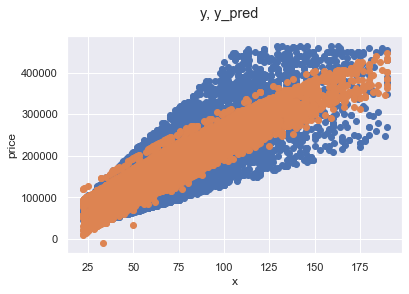

In [18]:
sns.set()
data_pred = pd.DataFrame(Dicto['data_pred'][0])
visualizacion_dos_scatter(data, data_pred, 'surface_total_in_m2', 'price', 'y_pred')

In [19]:
#Excepcion en llave
Dicto['models']
Dicto.keys()

dict_keys(['data_cruda', 'surface_nan', 'data', 'data_pred', 'dummy_place', 'models'])

In [20]:
Dicture['linreg'][0] # X de linreg

,surface_total_in_m2,sup_total_pow2,sup_descubierta_pct,above_mean,Abasto,Acassuso,Adrogué,Balvanera,Banfield,Barracas,...,San Nicolás,Santos Lugares,Victoria,Villa Bosch,Villa Crespo,Villa Devoto,Villa Luzuriaga,Villa Pueyrredón,Wilde,otros
0,55.0,3025.0,0.000000,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,40.0,1600.0,30.000000,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,52.0,2704.0,7.692308,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,50.0,2500.0,24.000000,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,51.0,2601.0,9.803922,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15937,36.0,1296.0,8.333333,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
15938,36.0,1296.0,8.333333,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
15939,30.0,900.0,6.666667,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
15940,34.0,1156.0,5.882353,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


--------------------
**EXPLORACION DE LA MUESTRA**

In [21]:
## Celda 18
serie_same = pd.Series(Dicto['dummy_place'][1])
serie_same;

serie_filter = pd.DataFrame(Dicto['data'][0])
serie_filter = serie_filter.place_name.unique()
serie_filter;

In [22]:
## Celda 19
muestra = pd.read_csv('muestra_currency_nan.csv')
muestra = muestra.drop(list(muestra.columns)[0], axis=1)
mask_1 = muestra.property_type == 'apartment'
mask_2 = muestra.place_name.isin(serie_same) # 2193 - 1959 = 230: muestras más, si en vez de usar serie_same, usamos serie filter, (obtenemos una muesrta más grande, y después hay que matchiar los otros con los otros) no vale

# Muestra_pred
muestra = muestra[mask_1 & mask_2]
display(muestra)
Dicto['muestra'] = muestra.to_dict(), data_info(muestra,'muestra').to_dict()
Dicto['muestra_pred'] = muestra.to_dict(), data_info(muestra,'muestra').to_dict()


## Muestra
muestra = variables_feature(muestra)
Dicto['muestra'] = muestra.to_dict(), data_info(muestra,'muestra').to_dict()
muestra

,property_type,place_name,state_name,price,currency,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2
35,apartment,La Plata,Bs.As. G.B.A. Zona Sur,NaN,NaN,55.0,55.0,NaN
46,apartment,Recoleta,Capital Federal,NaN,NaN,147.0,135.0,NaN
61,apartment,Balvanera,Capital Federal,NaN,NaN,76.0,76.0,NaN
74,apartment,La Plata,Bs.As. G.B.A. Zona Sur,NaN,NaN,120.0,120.0,NaN
75,apartment,Villa Devoto,Capital Federal,NaN,NaN,68.0,NaN,NaN
...,...,...,...,...,...,...,...,...
15530,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,100.0,94.0,NaN
15531,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,53.0,44.0,NaN
15533,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,52.0,48.0,NaN
15535,apartment,La Plata,Bs.As. G.B.A. Zona Sur,NaN,NaN,NaN,70.0,NaN


,property_type,place_name,state_name,price,currency,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,sup_total_pow2,sup_descubierta_pct
35,apartment,La Plata,Bs.As. G.B.A. Zona Sur,NaN,NaN,55.0,55.0,NaN,3025.0,0.000000
46,apartment,Recoleta,Capital Federal,NaN,NaN,147.0,135.0,NaN,21609.0,8.163265
61,apartment,Balvanera,Capital Federal,NaN,NaN,76.0,76.0,NaN,5776.0,0.000000
74,apartment,La Plata,Bs.As. G.B.A. Zona Sur,NaN,NaN,120.0,120.0,NaN,14400.0,0.000000
75,apartment,Villa Devoto,Capital Federal,NaN,NaN,68.0,NaN,NaN,4624.0,NaN
...,...,...,...,...,...,...,...,...,...,...
15530,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,100.0,94.0,NaN,10000.0,6.000000
15531,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,53.0,44.0,NaN,2809.0,16.981132
15533,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,52.0,48.0,NaN,2704.0,7.692308
15535,apartment,La Plata,Bs.As. G.B.A. Zona Sur,NaN,NaN,NaN,70.0,NaN,NaN,NaN


In [23]:
######### CONSERVANDO LAS DIMENSIONES EN TODAS LAS MUESTRAS

display (data_info(muestra,'muestra'))
analisis_nans(muestra.loc[:,['surface_total_in_m2', 'surface_covered_in_m2','place_name']])
print ()
print ('Accion a tomar: limpiar en funcion de los nans de "sup_descubierta_pct"')

muestra = muestra.loc[muestra.sup_descubierta_pct.notna()]
muestra = muestra.drop('surface_covered_in_m2', axis=1)
lista_filter = muestra.index

Dicto['muestra'] = muestra.to_dict(), data_info(muestra,'muestra').to_dict() # GUARDO MUESTRA

muestra = pd.DataFrame(Dicto['muestra_pred'][0]) # CARGO OTRA MUESRTA
muestra = muestra.filter(lista_filter, axis = 0) # MODIFICO OTRA MUESRTA
Dicto['muestra_pred'] = muestra.to_dict(), data_info(muestra,'muestra').to_dict() # GUARDO OTRA MUESRTA

muestra = pd.DataFrame(Dicto['muestra'][0]) # CARGO MUESTRA

df de muestra,columna,Nan,dtype,count,pct_nan,count_unique
index,,,,,,
0,property_type,0,object,1959,0.00,1
1,place_name,0,object,1959,0.00,46
2,state_name,0,object,1959,0.00,6
3,price,1959,float64,0,100.00,0
4,currency,1959,float64,0,100.00,0
5,surface_total_in_m2,147,float64,1812,7.50,210
6,surface_covered_in_m2,394,float64,1565,20.11,181
7,price_usd_per_m2,1959,float64,0,100.00,0
8,sup_total_pow2,147,float64,1812,7.50,210


ANALISIS DE NANS
surface_total_in_m2      147
surface_covered_in_m2    394
Cantidad de elemento: 1959
Interseccion entre los nan encuentra: 0 elementos
Union entre los nan encuentra: 541 elementos

Accion a tomar: limpiar en funcion de los nans de "sup_descubierta_pct"


In [24]:
## Celda 21
data_check = pd.read_csv('data_apartment_4_statistic.csv')
data_check = data_check.rename({'Unnamed: 0':'place_name'}, axis=1)
data_check.set_index('place_name', inplace=True)

apartment_mean = data_check['apartment_mean_surface_total_in_m2'].dropna()
lista_place_name = apartment_mean.index
lista_apartment_mean = apartment_mean.values

for i, elemento in enumerate(lista_place_name):
    #display(np.array((muestra.loc[mascara_iter_1 & (muestra.place_name == elemento), 'surface_total_in_m2']) >= lista_apartment_mean[i]).astype(int)) # columna dummy
    muestra.loc[(muestra.place_name == elemento), 'above_mean'] = np.array((muestra.loc[(muestra.place_name == elemento), 'surface_total_in_m2']) >= lista_apartment_mean[i]).astype(int)
    
muestra

,property_type,place_name,state_name,price,currency,surface_total_in_m2,price_usd_per_m2,sup_total_pow2,sup_descubierta_pct,above_mean
35,apartment,La Plata,Bs.As. G.B.A. Zona Sur,NaN,NaN,55.0,NaN,3025.0,0.000000,0.0
46,apartment,Recoleta,Capital Federal,NaN,NaN,147.0,NaN,21609.0,8.163265,1.0
61,apartment,Balvanera,Capital Federal,NaN,NaN,76.0,NaN,5776.0,0.000000,1.0
74,apartment,La Plata,Bs.As. G.B.A. Zona Sur,NaN,NaN,120.0,NaN,14400.0,0.000000,1.0
83,apartment,La Plata,Bs.As. G.B.A. Zona Sur,NaN,NaN,120.0,NaN,14400.0,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...
15529,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,100.0,NaN,10000.0,6.000000,1.0
15530,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,100.0,NaN,10000.0,6.000000,1.0
15531,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,53.0,NaN,2809.0,16.981132,1.0
15533,apartment,Castelar,Bs.As. G.B.A. Zona Oeste,NaN,NaN,52.0,NaN,2704.0,7.692308,1.0


In [25]:
##dummy de la muestra, reacondicionamiento
dummy_place_sample = pd.get_dummies(muestra.place_name)

lista_dummy_original = serie_same.values
lista_dummy_muestra = dummy_place_sample.columns

difference_1 = set(lista_dummy_original).difference(set(lista_dummy_muestra)) ##diference 1 es clave, son los valores que debo excluir del set de entrenamiento para mejorar la estimacion sobre la muestra
difference_2 = set(lista_dummy_muestra).difference(set(lista_dummy_original))
list_difference = list(difference_1.union(difference_2))
print(list_difference)#https://www.delftstack.com/es/howto/python/difference-between-two-lists-python/

dummy_place_sample.loc[:,difference_1] = 0
dummy_place_sample.columns;

['Barrio Los Alisos', 'Adrogué', 'San Justo', 'Wilde', 'otros', 'Beccar', 'Villa Bosch', 'Villa Luzuriaga']


In [26]:
###CHEQUEO DE NANS ENTRE INSTANCIAS DE MUESTRAS
Visualizar = False

if Visualizar:
    df = data_info(muestra)
    instancias = [pd.DataFrame(Dicto['muestra_pred'][1]), df]
    labels = ['muestra_1', 'muestra actual']
    sns.set()

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22,4))
    fig.suptitle('PORCENTAJE NANS [%]')
    fig.subplots_adjust(wspace = 0.4)

    for i in range(len(instancias)):
        df_i = instancias[i]
        ax[i].barh(df_i.columna, df_i.pct_nan)
        ax[i].set(xlim = (0,100), title='dataset: '+ labels[i])
        ax[i].minorticks_on()
        ax[i].grid(which='minor', axis='x', lw=1, alpha=0.4)

In [27]:
# Acá estuvimos manoseando muestra, y creamos X, acá aparece Dicture
X = pd.concat([muestra[features_1], dummy_place_sample], axis=1)
#podriamos predecir acá
Dicture['muestra_1'] = X,0,0,0,1

In [28]:
## Celda 25

array_predict = linreg.predict(X)

muestra_pred = pd.DataFrame(Dicto['muestra_pred'][0])
muestra_pred['y_pred'] = array_predict
Dicto['muestra_pred'] = muestra_pred.to_dict(), data_info(muestra_pred, 'muestra_pred').to_dict()


a = 'muestra_1'
Dicture[a] = Dicture[a][0], Dicture[a][1], Dicture[a][2], Dicture[a][3], array_predict

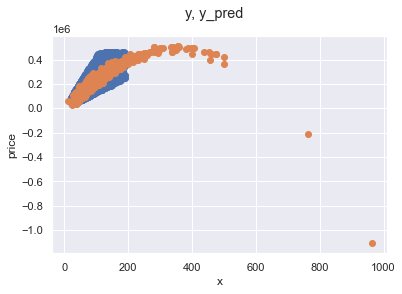

In [29]:
visualizacion_dos_scatter(data,muestra_pred, x='surface_total_in_m2', y_1='price', y_2='y_pred')
# x: surface_total_in_m2
# puntos azules: valores reales de departamentos
# puntos naranjas: valores predicho sobre una muestra sin valores reales

    Conclusion:
        
        - El modelo predice mal para valores grandes de departamentos.
        - Se debe diferenciar por place_name para identificar los barrios en los que el modelo responde al patrón de precios

------------
**COMPROBACION VISUAL DEL RANGO DE APLICACION DEL MODELO**

In [30]:
## Celda 27
dataview_1 = data[['property_type','surface_total_in_m2']]
dataview_1['place_name'] = place_name_2
dataview_1['price'] = data.price

dataview_1['id'] = 1

dataview_1

,property_type,surface_total_in_m2,place_name,price,id
0,apartment,55.0,Mataderos,72000.000000,1
1,apartment,40.0,Mataderos,67000.000000,1
2,apartment,52.0,Mataderos,90000.000000,1
3,apartment,50.0,Mataderos,88000.000000,1
4,apartment,51.0,Mataderos,93600.000000,1
...,...,...,...,...,...
15937,apartment,36.0,otros,63759.245132,1
15938,apartment,36.0,otros,63759.245132,1
15939,apartment,30.0,otros,52140.893797,1
15940,apartment,34.0,otros,58375.131099,1


In [31]:
dataview_2 = muestra_pred[['property_type', 'surface_total_in_m2', 'place_name', 'y_pred']]

place_missing = set(place_name_2).difference(set(muestra_pred.place_name)) # eliminar de la muestra original

dataview_2['id'] = 2

dataview_2

,property_type,surface_total_in_m2,place_name,y_pred,id
35,apartment,55.0,La Plata,108106.151532,2
46,apartment,147.0,Recoleta,309238.719875,2
61,apartment,76.0,Balvanera,196266.112129,2
74,apartment,120.0,La Plata,253111.530299,2
83,apartment,120.0,La Plata,253111.530299,2
...,...,...,...,...,...
15529,apartment,100.0,Castelar,219135.728994,2
15530,apartment,100.0,Castelar,219135.728994,2
15531,apartment,53.0,Castelar,100094.108227,2
15533,apartment,52.0,Castelar,103782.384828,2


In [32]:
## Celda 29
dataview_1 = dataview_1.drop(dataview_1[dataview_1.place_name.isin(list(place_missing))].index)
#
print ('Si eliminamos los elementos de place_missing de la muestra de entrenamiento, estaríamos entrenando ajustando a esta muestra de verificacion.')
#
dataview_1

Si eliminamos los elementos de place_missing de la muestra de entrenamiento, estaríamos entrenando ajustando a esta muestra de verificacion.


,property_type,surface_total_in_m2,place_name,price,id
0,apartment,55.0,Mataderos,72000.000000,1
1,apartment,40.0,Mataderos,67000.000000,1
2,apartment,52.0,Mataderos,90000.000000,1
3,apartment,50.0,Mataderos,88000.000000,1
4,apartment,51.0,Mataderos,93600.000000,1
...,...,...,...,...,...
15638,apartment,75.0,Güemes,168000.000000,1
15639,apartment,75.0,Güemes,155546.714375,1
15640,apartment,61.0,Güemes,132000.000000,1
15641,apartment,61.0,Güemes,123511.349226,1


In [33]:
dataview_2.rename({'y_pred': 'price'}, axis=1, inplace=True)
dataview_1 = dataview_1.append(dataview_2)

In [34]:
## Celda 31 - A VER (!)
#g = sns.FacetGrid(dataview_1, row = 'place_name', hue='id', sharex=False, sharey=False)
#g.map(sns.scatterplot, 'surface_total_in_m2', 'price')
#g.add_legend()


###  Parte 2 - Ridge

In [35]:
import numpy as np
import pandas as pd


from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [36]:
def check_fit_transform(X):
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    X.columns.name = 'fit_transform'
    return display(X)

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11998 entries, 0 to 15941
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   property_type        11998 non-null  object 
 1   place_name           11998 non-null  object 
 2   state_name           11998 non-null  object 
 3   price                11998 non-null  float64
 4   currency             11998 non-null  object 
 5   surface_total_in_m2  11998 non-null  float64
 6   price_usd_per_m2     11998 non-null  float64
 7   above_mean           11998 non-null  float64
 8   sup_total_pow2       11998 non-null  float64
 9   sup_descubierta_pct  11998 non-null  float64
dtypes: float64(6), object(4)
memory usage: 1.3+ MB


In [38]:
## Celda 36

scaler = StandardScaler()

df = data_info(data)
## data.loc[:,data.columns.isin(df[df['dtype'] == 'float64'].columna.values)] #check
X = data.loc[:,data.columns.isin(df[df['dtype'] == 'float64'].columna.values)]
X = X.drop(['price', 'above_mean', 'price_usd_per_m2'], axis=1)

Dicture['model_ridge_cv'] = X,1,0,0,0



y = data.price

Dicture['model_ridge_cv'] = X,y,0,0,0


check_fit_transform(X) #funcion creada


X_std = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


Dicture['model_ridge_cv'] = X_std,y,0,0,0


X_std.columns.name='X_std'
display (X_std)


fit_transform,surface_total_in_m2,sup_total_pow2,sup_descubierta_pct
0,-0.330335,-0.406726,-0.901216
1,-0.815811,-0.672402,1.775178
2,-0.427430,-0.466573,-0.214961
3,-0.492160,-0.504607,1.239899
4,-0.459795,-0.485777,-0.026578
...,...,...,...
11993,-0.945271,-0.729080,-0.157773
11994,-0.945271,-0.729080,-0.157773
11995,-1.139461,-0.802910,-0.306462
11996,-1.010001,-0.755181,-0.376433


X_std,surface_total_in_m2,sup_total_pow2,sup_descubierta_pct
0,-0.330335,-0.406726,-0.901216
1,-0.815811,-0.672402,1.775178
2,-0.427430,-0.466573,-0.214961
3,-0.492160,-0.504607,1.239899
4,-0.459795,-0.485777,-0.026578
...,...,...,...
11993,-0.945271,-0.729080,-0.157773
11994,-0.945271,-0.729080,-0.157773
11995,-1.139461,-0.802910,-0.306462
11996,-1.010001,-0.755181,-0.376433


In [39]:
### ACA TENEMOS QUE ACTUALIZAR Dicto[models] pero vamos a esperar para hacerlo en 2 modelos al mismo tiempo

# nueva convencion: si se crea un modelo y se fitea en otra variable se crea un string de la instanciacion con los hiperparámetros

Dicture['model_ridge_cv'] = X_std,y,0,0,0, 'str'

In [40]:
# 4 Division
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.3, random_state = 117)

#1 y 2. Defino el modelo y los hiperparámetros - #creo un modelo que no lo entreno
model_ridge_cv = linear_model.RidgeCV(alphas= [0.3, 0.5, 1.0, 1.1, 1.15, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.3, 1.4, 1.5, 10.0], 
                                   fit_intercept=True, normalize=False, cv=10)

#agregar #1 y 2 en string
Dicture['model_ridge_cv'] = Dicture['model_ridge_cv'][0],Dicture['model_ridge_cv'][1], Dicture['model_ridge_cv'][2], Dicture['model_ridge_cv'][3],Dicture['model_ridge_cv'][3], 'model_ridge_cv = linear_model.RidgeCV(alphas= [0.3, 0.5, 1.0, 1.1, 1.15, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.3, 1.4, 1.5, 10.0], fit_intercept=True, normalize=False, cv=10)'


#5. Entreno el modelo
model_fit_ridge_cv = model_ridge_cv.fit(X_train, y_train)
Model['model_fit_ridge_cv'] = model_fit_ridge_cv, 0, 0

array_predict = model_fit_ridge_cv.predict(X_train)
Dicture['model_fit_ridge_cv'] = X_std, y, 1, 1, 1, 1, 'str'
Dicture['model_fit_ridge_cv'] = X_std,y,pd.DataFrame({'B_0': {'model_fit_ridge_cv':model_fit_ridge_cv.intercept_}}), model_fit_ridge_cv.coef_, array_predict, model_fit_ridge_cv.alpha_, str(model_fit_ridge_cv.best_score_)

Model['model_fit_ridge_cv'] = Model['model_fit_ridge_cv'][0], Dicture['model_fit_ridge_cv'], Model['model_fit_ridge_cv'][2]

In [41]:
### Parámetros del modelo entrenado, performance:

print(f'alpha_: {"%.2f" % model_fit_ridge_cv.alpha_}')
print(f'best_score_: {"%.2f" % model_fit_ridge_cv.best_score_}')

alpha_: 1.00
best_score_: 0.72


In [42]:
#. elijo el modelo

best_alpha = model_fit_ridge_cv.alpha_
model_ridge = linear_model.Ridge(alpha = best_alpha, fit_intercept = True, normalize = False)

In [43]:
Dicture['model_ridge'] = X_std, y, 0, 0, 0, 'model_ridge = linear_model.Ridge(alpha = best_alpha, fit_intercept = True, normalize = False)'

Dicture['model_fit_ridge'] = X_std, y, 1 ,1, 1, 'str'

In [44]:
#. entreno
model_fit_ridge = model_ridge.fit(X_train, y_train)


Model['model_fit_ridge'] = model_fit_ridge, 1, 1
array_predict = model_fit_ridge.predict(X_train)
Dicture['model_fit_ridge'] = Dicture['model_fit_ridge'][0],Dicture['model_fit_ridge'][1], pd.DataFrame({'B_0':{'model_fit_ridge':model_fit_ridge.intercept_}}), model_fit_ridge.coef_, array_predict, str(model_fit_ridge.score(X_train, y_train))

# Exposicion de modelo:
print(model_fit_ridge.coef_)
print(model_fit_ridge.intercept_)
print(model_fit_ridge.score(X_train, y_train))

[ 94609.04185075 -21086.11847467  -5106.73881089]
157599.96476792355
0.7229801577388337


In [45]:
## EVALUACION DE LA PERFOMANCE DEL MODELO CON RIDGE
model_fit_ridge.score(X_test, y_test)

# Conclusion: expresar la formula y verificar por coeficientes que sean iguales

0.7198657986125305

------------------
Actualizacion de Dicto
--------------
-------

In [46]:
## crear funcion en base a la celda de abajo

def actualizar_Dicto_models():
    difference_3 = set(Model.keys()).difference(set(Dicto['models'].index))
    print (difference_3)
    
    for indice in difference_3:
        
        try:
            if Dicture[indice][3] == 0: 
                etiqueta = '\n\tINTERCEPTO NO DEFINIDO EN "{}"\n'.format(indice)
                print ('='*80+etiqueta+'='*80)            
                pass
            if Dicture[indice][3] == 1:
                etiqueta = '\n\tNO ESTA DEFINIDO EL INTERCEPTO EN "{}"\n'.format(indice)
                print ('='*40+etiqueta+'='*40)
                pass
        except:
            frame = dict(zip(list(Dicture[indice][0].columns) , list(Dicture[indice][3])))    # el list es importante para borrar el name a la column
            frame = pd.DataFrame({indice: pd.Series(frame)}).T
            frame = (Dicture[indice][2]).join(frame)
            Dicto['models'] = Dicto['models'].append(frame)
        
"""
---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
~\AppData\Local\Temp/ipykernel_2120/3502676010.py in <module>
      1 display (Dicto['models'])
----> 2 actualizar_Dicto_models()
      3 display (Dicto['models'])

~\AppData\Local\Temp/ipykernel_2120/257676095.py in actualizar_Dicto_models()
      6 
      7     for indice in difference_3:
----> 8         frame = dict(zip(list(Dicture[indice][0].columns) , list(Dicture[indice][3])))    # el list es importante para borrar el name a la column
      9         frame = pd.DataFrame({indice: pd.Series(frame)}).T
     10         frame = (Dicture[indice][2]).join(frame)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'



---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
~\AppData\Local\Temp/ipykernel_8652/3502676010.py in <module>
      1 display (Dicto['models'])
----> 2 actualizar_Dicto_models()
      3 display (Dicto['models'])

~\AppData\Local\Temp/ipykernel_8652/2550046604.py in actualizar_Dicto_models()
      6 
      7     for indice in difference_3:
----> 8         frame = dict(zip(list(Dicture[indice][0].columns) , list(Dicture[indice][3])))    # el list es importante para borrar el name a la column
      9         frame = pd.DataFrame({indice: pd.Series(frame)}).T
     10         frame = (Dicture[indice][2]).join(frame)

TypeError: 'int' object is not iterable
    
    """;

In [47]:
difference_3 = set(Model.keys()).difference(set(Dicto['models'].index))
print (difference_3)

for indice in difference_3:

    Dicture[indice][2]# + pd.DataFrame(Dicture['model_fit_ridge_cv'][3])

    frame = dict(zip(list(Dicture[indice][0].columns) , list(Dicture[indice][3])))    # el list es importante para borrar el name a la column

    frame = pd.DataFrame({indice: pd.Series(frame)}).T

    frame = (Dicture[indice][2]).join(frame)
    
    display (frame)
    Dicto['models'] = Dicto['models'].append(frame)
    
Dicto['models']

{'model_fit_ridge', 'model_fit_ridge_cv'}


,B_0,surface_total_in_m2,sup_total_pow2,sup_descubierta_pct
model_fit_ridge,157599.964768,94609.041851,-21086.118475,-5106.738811


,B_0,surface_total_in_m2,sup_total_pow2,sup_descubierta_pct
model_fit_ridge_cv,157599.964768,94609.041851,-21086.118475,-5106.738811


,B_0,surface_total_in_m2,sup_total_pow2,sup_descubierta_pct,above_mean,Abasto,Acassuso,Adrogué,Balvanera,Banfield,...,San Nicolás,Santos Lugares,Victoria,Villa Bosch,Villa Crespo,Villa Devoto,Villa Luzuriaga,Villa Pueyrredón,Wilde,otros
linreg,-9937.248892,3022.893016,-4.233447,-674.644869,-3327.210774,-14166.439444,15875.596065,4243.090847,-32848.633034,-26120.631942,...,-19238.136997,-36862.94185,2615.471643,-34085.57149,4461.689484,-6837.738448,-41009.703198,-1672.322151,-38066.720057,-22402.528691
model_fit_ridge,157599.964768,94609.041851,-21086.118475,-5106.738811,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_fit_ridge_cv,157599.964768,94609.041851,-21086.118475,-5106.738811,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<u>**Evaluacion del modelo sobre la muestra**<u>

In [48]:
df = data_info(muestra,'muestra')
columnas_float = df.loc[(df['dtype'] == 'float64'), 'columna'].values

muestra = muestra.loc[:,columnas_float].dropna(axis=1)

muestra

,surface_total_in_m2,sup_total_pow2,sup_descubierta_pct,above_mean
35,55.0,3025.0,0.000000,0.0
46,147.0,21609.0,8.163265,1.0
61,76.0,5776.0,0.000000,1.0
74,120.0,14400.0,0.000000,1.0
83,120.0,14400.0,0.000000,1.0
...,...,...,...,...
15529,100.0,10000.0,6.000000,1.0
15530,100.0,10000.0,6.000000,1.0
15531,53.0,2809.0,16.981132,1.0
15533,52.0,2704.0,7.692308,1.0


In [49]:
# ya sabemos que normalizar no admite dummys
Dicto['muestra'] = muestra.to_dict(), data_info(muestra,'muestra')
muestra.drop('above_mean', axis=1, inplace=True)

In [50]:
check_fit_transform(muestra)
X = scaler.fit_transform(muestra)
Dicture['muestra_2'] = X,0,0,0,1,'y_pred_muestra_currency_nan' # el 1 porque me interesa ese valor son 3 dataset y 2 array, y 1 string

muestra = pd.DataFrame(Dicto['muestra_pred'][0])
array_predict = model_fit_ridge.predict(X)
muestra['y_pred_ridge'] = array_predict
Dicto['muestra_pred'] = muestra.to_dict(), data_info(muestra,'muestra_pred').to_dict()

muestra = pd.DataFrame(Dicto['muestra'][0])

fit_transform,surface_total_in_m2,sup_total_pow2,sup_descubierta_pct
0,-0.396411,-0.236620,-0.889884
1,0.893413,0.252117,-0.263393
2,-0.101995,-0.164272,-0.889884
3,0.514877,0.062529,-0.889884
4,0.514877,0.062529,-0.889884
...,...,...,...
1413,0.234481,-0.053186,-0.429413
1414,0.234481,-0.053186,-0.429413
1415,-0.424451,-0.242300,0.413336
1416,-0.438470,-0.245062,-0.299536


In [51]:

muestra

,surface_total_in_m2,sup_total_pow2,sup_descubierta_pct,above_mean
35,55.0,3025.0,0.000000,0.0
46,147.0,21609.0,8.163265,1.0
61,76.0,5776.0,0.000000,1.0
74,120.0,14400.0,0.000000,1.0
83,120.0,14400.0,0.000000,1.0
...,...,...,...,...
15529,100.0,10000.0,6.000000,1.0
15530,100.0,10000.0,6.000000,1.0
15531,53.0,2809.0,16.981132,1.0
15533,52.0,2704.0,7.692308,1.0


In [52]:
data
#Dicture['model_lasso_cv'][0]
list(data.iloc[:,3:10].iloc[:,4:].columns)

['above_mean', 'sup_total_pow2', 'sup_descubierta_pct']

###  Parte 3 Lasso

In [53]:
# IMPORTS FOR LASSO
import numpy as np
import pandas as pd

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ASUMIENDO TODAS NUESRTAS VARIABLE NUMERICAS
feature = ['surface_total_in_m2','sup_total_pow2','sup_descubierta_pct','above_mean']
X = data[feature]
scaler = StandardScaler()

X_std = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)# <------------------------- así se hace
#X_std['above_mean'] = X['above_mean'] ## es raro que lasso acepte dummy estandarizada pero no con 0 y 1

y = data.price


Dicture['model_lasso_cv'] = X_std, y, 0,0,0, 'linear_model.LassoCV(alphas= [0.05, 0.06, 0.07, 0.08, 0.09, 0.95, 0.97, 0.1, 0.12, 0.15, 0.2, 0.3, 1.0, 10.0], fit_intercept=True, normalize=False, cv=10, max_iter=1e4)'
Dicture['model_fit_lasso_cv'] = X_std, y, 0,0,0,'hiperparámetros: take_it'
Dicture['model_lasso'] = X_std,y,0,0,0,'model_lasso = linear_model.Lasso(alpha = take_it, fit_intercept = True, normalize = False)'
Dicture['model_fit_lasso'] = X_std,y,1,1,0,'performance'


# (3)
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.3, random_state = 117)
# (1), (2)
model_lasso_cv = linear_model.LassoCV(alphas= [0.05, 0.06, 0.07, 0.08, 0.09, 0.95, 0.97, 0.1, 0.12, 0.15, 0.2, 0.3, 1.0, 10.0], 
                                   fit_intercept=True, normalize=False, cv=10, max_iter=1e4)
# (5)
model_fit_lasso_cv = model_lasso_cv.fit(X_train, y_train)


indice='model_fit_lasso_cv'
Dicture['model_fit_lasso_cv'] = Dicture[indice][0], Dicture[indice][1], Dicture[indice][2], Dicture[indice][2], Dicture[indice][4], model_fit_lasso_cv.alpha_, str(model_fit_lasso_cv.score(X_train, y_train))
Model[indice] = model_fit_lasso_cv, 1, Dicture[indice]

print(Dicture['model_fit_lasso_cv'][5])
print(Dicture['model_fit_lasso_cv'][6])

# (1, 2)
take_it = Dicture['model_fit_lasso_cv'][5] # model_fit_lasso_cv.alpha_
model_lasso = linear_model.Lasso(alpha = take_it, fit_intercept = True, normalize = False)

# (5)
model_fit_lasso = model_lasso.fit(X_train, y_train)
indice= 'model_fit_lasso'
#array_predict = predecir modelo con X_train: no, entonces cero
Dicture['model_fit_lasso'] = X_std,y, pd.DataFrame({'B_0': {indice:model_fit_lasso.intercept_}}), model_fit_lasso.coef_, 0, str(model_fit_lasso.score(X_test, y_test))

Model[indice] = model_fit_lasso, 1, Dicture[indice]

print(model_fit_lasso.coef_)
print(model_fit_lasso.intercept_)
print(model_fit_lasso.score(X_test, y_test))

0.05
0.7272384189120737
[112229.92673503 -31900.0780448   -5225.29672557  -9349.09066318]
157584.84344429235
0.7246395515095462


In [54]:
Dicture['model_fit_lasso_cv'][3]

0

In [55]:
display (Dicto['models'])
actualizar_Dicto_models()
display (Dicto['models'])

,B_0,surface_total_in_m2,sup_total_pow2,sup_descubierta_pct,above_mean,Abasto,Acassuso,Adrogué,Balvanera,Banfield,...,San Nicolás,Santos Lugares,Victoria,Villa Bosch,Villa Crespo,Villa Devoto,Villa Luzuriaga,Villa Pueyrredón,Wilde,otros
linreg,-9937.248892,3022.893016,-4.233447,-674.644869,-3327.210774,-14166.439444,15875.596065,4243.090847,-32848.633034,-26120.631942,...,-19238.136997,-36862.94185,2615.471643,-34085.57149,4461.689484,-6837.738448,-41009.703198,-1672.322151,-38066.720057,-22402.528691
model_fit_ridge,157599.964768,94609.041851,-21086.118475,-5106.738811,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_fit_ridge_cv,157599.964768,94609.041851,-21086.118475,-5106.738811,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


{'model_fit_lasso_cv', 'model_fit_lasso'}
	INTERCEPTO NO DEFINIDO EN "model_fit_lasso_cv"


,B_0,surface_total_in_m2,sup_total_pow2,sup_descubierta_pct,above_mean,Abasto,Acassuso,Adrogué,Balvanera,Banfield,...,San Nicolás,Santos Lugares,Victoria,Villa Bosch,Villa Crespo,Villa Devoto,Villa Luzuriaga,Villa Pueyrredón,Wilde,otros
linreg,-9937.248892,3022.893016,-4.233447,-674.644869,-3327.210774,-14166.439444,15875.596065,4243.090847,-32848.633034,-26120.631942,...,-19238.136997,-36862.94185,2615.471643,-34085.57149,4461.689484,-6837.738448,-41009.703198,-1672.322151,-38066.720057,-22402.528691
model_fit_ridge,157599.964768,94609.041851,-21086.118475,-5106.738811,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_fit_ridge_cv,157599.964768,94609.041851,-21086.118475,-5106.738811,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_fit_lasso,157584.843444,112229.926735,-31900.078045,-5225.296726,-9349.090663,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<u>**APLICO EL MODELO A LA MUESTRA**<U>

In [56]:
Dicture['model_fit_lasso'][0]

,surface_total_in_m2,sup_total_pow2,sup_descubierta_pct,above_mean
0,-0.330335,-0.406726,-0.901216,-0.806439
1,-0.815811,-0.672402,1.775178,-0.806439
2,-0.427430,-0.466573,-0.214961,-0.806439
3,-0.492160,-0.504607,1.239899,-0.806439
4,-0.459795,-0.485777,-0.026578,-0.806439
...,...,...,...,...
11993,-0.945271,-0.729080,-0.157773,-0.806439
11994,-0.945271,-0.729080,-0.157773,-0.806439
11995,-1.139461,-0.802910,-0.306462,-0.806439
11996,-1.010001,-0.755181,-0.376433,-0.806439


In [57]:
scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(muestra), columns=muestra.columns)
Dicture['muestra_3'] = X_std,0,0,0,1,'prediccion lasso sobre muestra currency_nan'

array_predict = model_fit_lasso.predict(X_std)
Dicture['muestra_3'] = X_std,0,0,0,array_predict,'prediccion lasso sobre muestra currency_nan'

muestra_pred = pd.DataFrame(Dicto['muestra_pred'][0])
muestra_pred['y_pred_lasso'] = array_predict

Dicto['muestra_pred'] = muestra_pred.to_dict(), data_info(muestra_pred, 'muestra_pred').to_dict()

In [58]:
data_aux = Dicture['linreg'][0]

data_aux
x = data_aux.surface_total_in_m2
x
y = Dicture['linreg'][4]
y

array([114666.94092472,  85437.48544443, 103173.94032773, ...,
       183902.6427086 , 145981.25861524, 184127.53753898])

###  COMPROBACION VISUAL DE LOS MODELOS



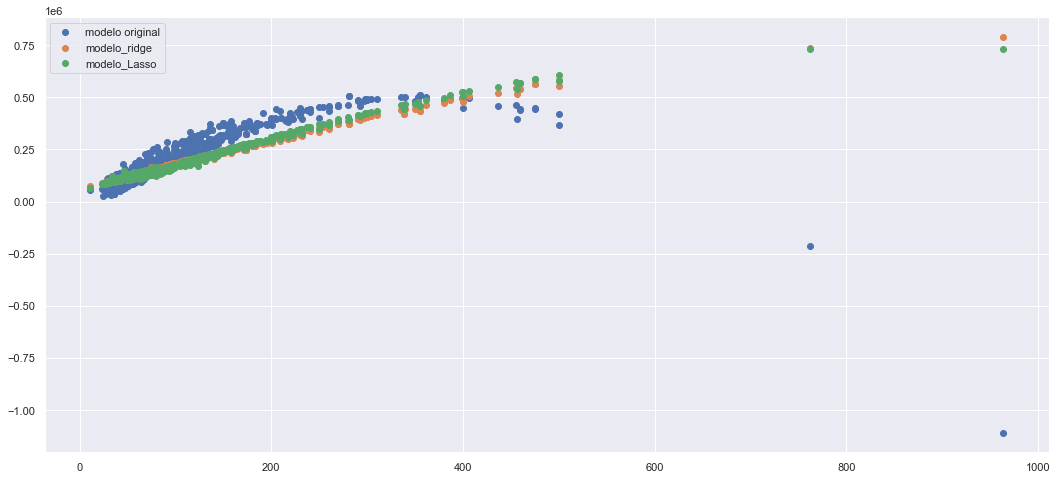

In [59]:
fig = plt.figure(figsize = (18,8))


### error en dicture: la y_pred de entrnamiento no es del same len que el X del [0]
#data_aux = Dicture['linreg'][0]
#x = data_aux.surface_total_in_m2
#y = Dicture['linreg'][4]
#plt.scatter(x,y, label='modelo entrenamiento')


x = muestra.surface_total_in_m2
y = muestra_pred.y_pred
plt.scatter(x,y, label='modelo original')
y = muestra_pred.y_pred_ridge
plt.scatter(x, y, label='modelo_ridge')
y = muestra_pred.y_pred_lasso
plt.scatter(x, y, label='modelo_Lasso')

plt.legend()


### MODELO ORIGINAL

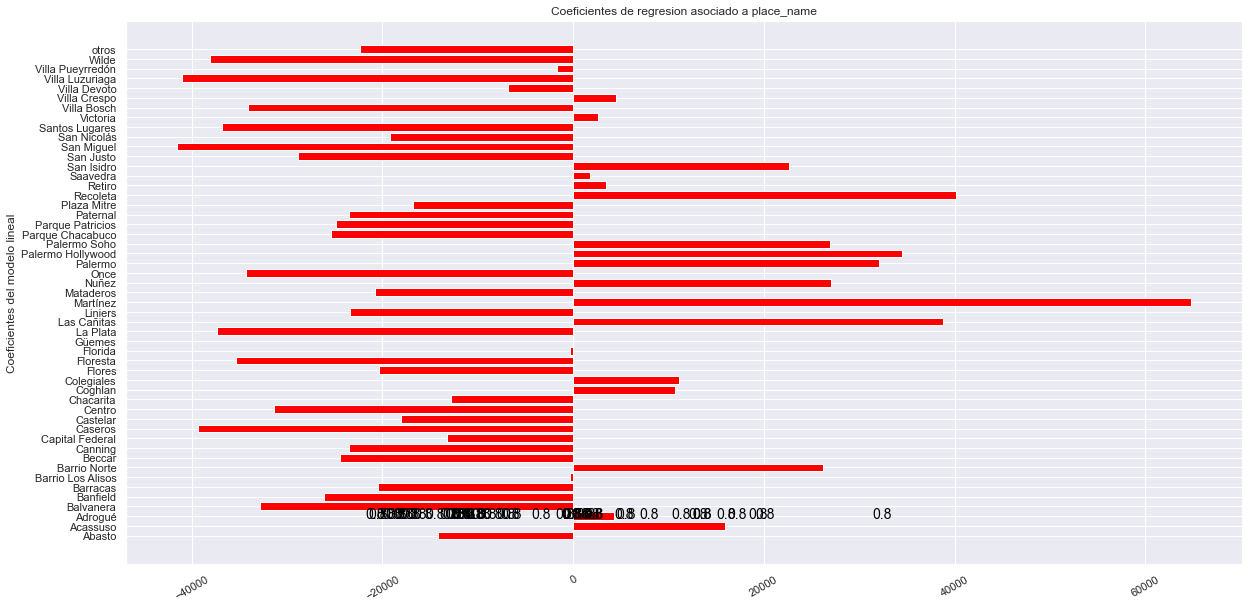

In [60]:
# NECESITO SOLO LOS COEFICIENTES DE LOS LUGARES Y LOS COEFICIENTES SON: SUPERFICIE_TOTAL, SUPERFICIE_POW2, SUP_DESCU_PCT, ABOVE_MEAN
feature_cols = list(pd.DataFrame(Dicto['dummy_place'][0]).columns)
lista_coeficientes = list(linreg.coef_)
lista_coeficientes_dummy_place = lista_coeficientes[4:] #las primera 4 columnas son de otra cosa

fig, ax=plt.subplots(figsize=(20,10))
barras=ax.barh(feature_cols, lista_coeficientes_dummy_place, color='red')
#ax.axhline(0, color='black',linewidth=1)
ax.set_ylabel('Coeficientes del modelo lineal')
plt.xticks(rotation=30);
plt.title('Coeficientes de regresion asociado a place_name')

for barra in barras:
    x=barra.get_x()
    y=barra.get_height()
    ancho=barra.get_width()
    if y>0:
        plt.text(x+ancho/2,y+1,round(y,2),fontsize=14,color='black',ha='center',size=14)
    else:
        plt.text(x+ancho/2,y-10,round(y,2),fontsize=14,color='black',ha='center',size=14)

#################################################################################################
# Clasificacion

vamos a partir de algunas premisas:

1. La mejor generalización la hizo en "La Plata", y que existe la posibilidad de extraer la muestra completa del dataset (deptos)

2. Voy a armar una matriz de correlación y me voy a quedar con todos los place_name que correlaciones con la Plata mas de 55

*4. Voy a eliminar los place_missing de la muestra de entrenamiento

In [61]:
Dicto.keys()

dict_keys(['data_cruda', 'surface_nan', 'data', 'data_pred', 'dummy_place', 'models', 'muestra', 'muestra_pred'])

In [62]:
data = pd.DataFrame(Dicto['data'][0])
la_plata = data[data.place_name == 'La Plata']
la_plata

,property_type,place_name,state_name,price,currency,surface_total_in_m2,price_usd_per_m2,above_mean,sup_total_pow2,sup_descubierta_pct
8724,apartment,La Plata,Bs.As. G.B.A. Zona Sur,103715.038748,USD,59.0,1739.544407,0.0,3481.0,0.000000
8725,apartment,La Plata,Bs.As. G.B.A. Zona Sur,83312.080306,USD,45.0,1832.066667,0.0,2025.0,0.000000
8726,apartment,La Plata,Bs.As. G.B.A. Zona Sur,109382.527205,USD,59.0,1834.601525,0.0,3481.0,0.000000
8727,apartment,La Plata,Bs.As. G.B.A. Zona Sur,290000.000000,USD,147.0,1972.789116,1.0,21609.0,0.000000
8731,apartment,La Plata,Bs.As. G.B.A. Zona Sur,175000.000000,USD,74.0,2364.864865,1.0,5476.0,8.108108
...,...,...,...,...,...,...,...,...,...,...
9528,apartment,La Plata,Bs.As. G.B.A. Zona Sur,155000.000000,USD,75.0,2066.666667,1.0,5625.0,0.000000
9535,apartment,La Plata,Bs.As. G.B.A. Zona Sur,110000.000000,USD,59.0,1864.406780,0.0,3481.0,0.000000
9536,apartment,La Plata,Bs.As. G.B.A. Zona Sur,70000.000000,USD,36.0,1944.444444,0.0,1296.0,0.000000
9537,apartment,La Plata,Bs.As. G.B.A. Zona Sur,88671.824139,USD,49.0,1790.751633,0.0,2401.0,8.163265


In [83]:
la_plata.sort_values(by='surface_total_in_m2', ascending=True, inplace=True)
la_plata['surface_pct_change'] = la_plata.surface_total_in_m2.pct_change()*100
la_plata['price_pct_change'] = la_plata.price.pct_change()*100

la_plata.reset_index(drop=True,inplace=True)
la_plata['price_pct_change_positive'] = la_plata.eval('price_pct_change > 0')
la_plata['changing_surface'] = la_plata.eval('surface_pct_change > 0.2 and surface_pct_change < 4')
la_plata

,property_type,place_name,state_name,price,currency,surface_total_in_m2,price_usd_per_m2,above_mean,sup_total_pow2,sup_descubierta_pct,surface_pct_change,price_pct_change,price_pct_change_positive,changing_surface
0,apartment,La Plata,Bs.As. G.B.A. Zona Sur,50000.000000,USD,25.0,2000.000000,0.0,625.0,0.000000,NaN,NaN,False,False
1,apartment,La Plata,Bs.As. G.B.A. Zona Sur,44773.158804,USD,27.0,1640.966667,0.0,729.0,0.000000,8.000000,-10.453682,False,False
2,apartment,La Plata,Bs.As. G.B.A. Zona Sur,53000.000000,USD,28.0,1892.857143,0.0,784.0,0.000000,3.703704,18.374494,True,True
3,apartment,La Plata,Bs.As. G.B.A. Zona Sur,70000.000000,USD,29.0,2413.793103,0.0,841.0,0.000000,3.571429,32.075472,True,True
4,apartment,La Plata,Bs.As. G.B.A. Zona Sur,52000.000000,USD,30.0,1733.333333,0.0,900.0,0.000000,3.448276,-25.714286,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,apartment,La Plata,Bs.As. G.B.A. Zona Sur,410300.000000,USD,144.0,2849.305556,1.0,20736.0,9.027778,0.000000,20.676471,True,False
413,apartment,La Plata,Bs.As. G.B.A. Zona Sur,385000.000000,USD,145.0,2655.172414,1.0,21025.0,10.344828,0.694444,-6.166220,False,True
414,apartment,La Plata,Bs.As. G.B.A. Zona Sur,290000.000000,USD,147.0,1972.789116,1.0,21609.0,0.000000,1.379310,-24.675325,False,True
415,apartment,La Plata,Bs.As. G.B.A. Zona Sur,290000.000000,USD,147.0,1972.789116,1.0,21609.0,0.000000,0.000000,0.000000,False,False


Text(0.5, 0, 'indice superficies crecientes')

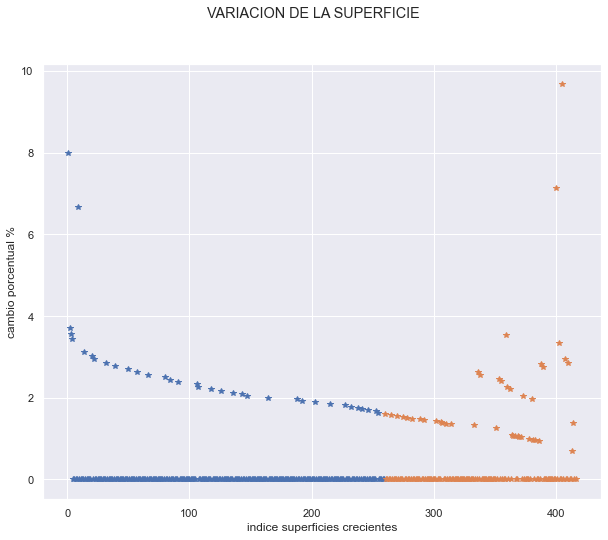

In [77]:
mask = la_plata.above_mean == 0
plt.figure(figsize=(10,8))
plt.plot(la_plata[mask].surface_pct_change, '*')
plt.plot(la_plata[~mask].surface_pct_change, '*')
plt.suptitle('VARIACION DE LA SUPERFICIE')
plt.ylabel('cambio porcentual %')
plt.xlabel('indice superficies crecientes')

Text(0.5, 0, 'indice crecientes')

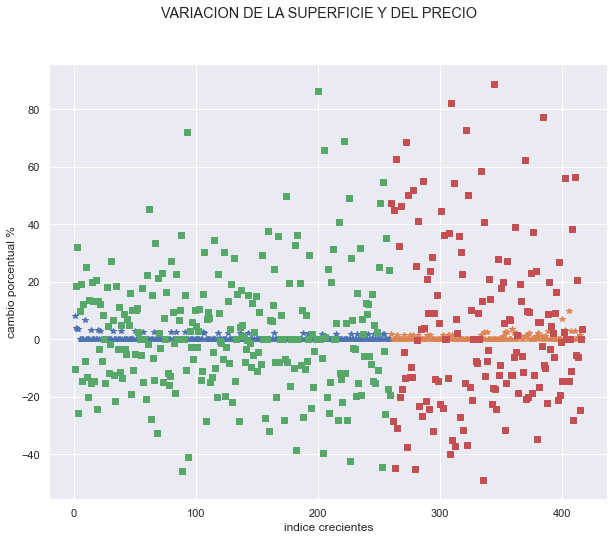

In [80]:
mask = la_plata.above_mean == 0

plt.figure(figsize=(10,8))
plt.plot(la_plata[mask].surface_pct_change, '*')
plt.plot(la_plata[~mask].surface_pct_change, '*')
plt.plot(la_plata[mask].price_pct_change, 's')
plt.plot(la_plata[~mask].price_pct_change, 's')
plt.suptitle('VARIACION DE LA SUPERFICIE Y DEL PRECIO')
plt.ylabel('cambio porcentual %')
plt.xlabel('indice crecientes')

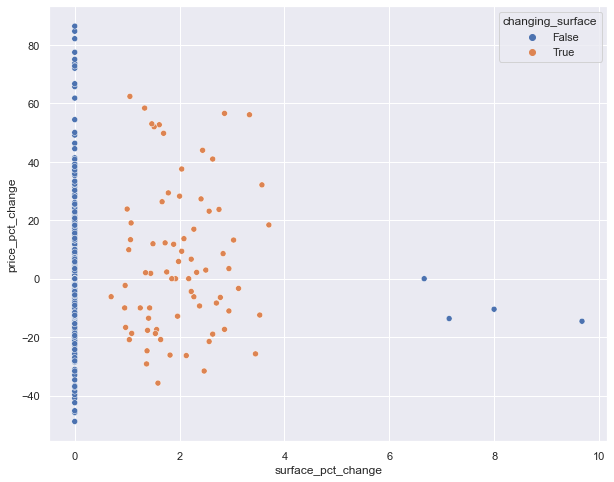

In [86]:
plt.figure(figsize=(10,8))
g = sns.scatterplot(x='surface_pct_change', y='price_pct_change', data=la_plata, hue='changing_surface')
#g.axis("equal")

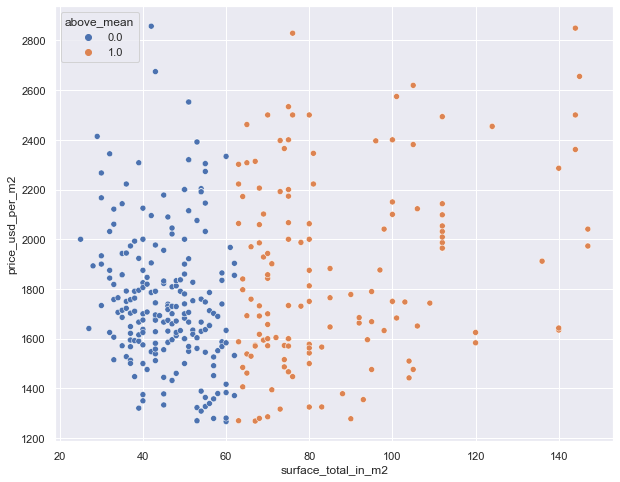

In [91]:
plt.figure(figsize=(10,8))
g = sns.scatterplot(x='surface_total_in_m2', y='price_usd_per_m2', data=la_plata, hue='above_mean')
#g.axis("equal")

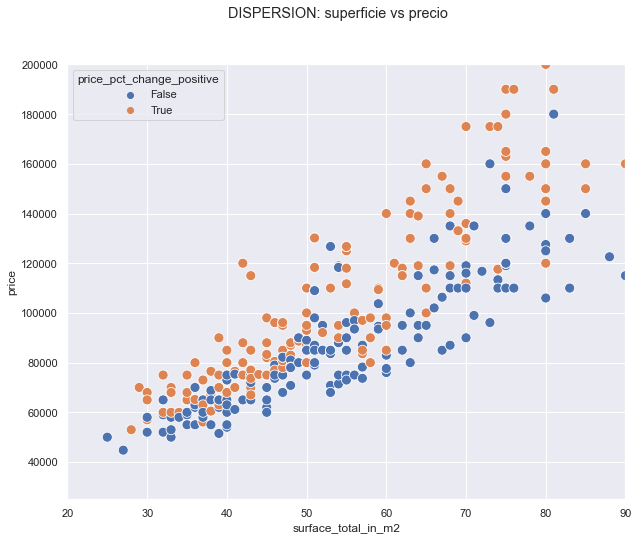

In [131]:
fig = plt.figure(figsize=(10,8))
fig.suptitle('DISPERSION: superficie vs precio')
ax = plt.axes()

ax.set(xlim=(20,90), ylim=(25000,200000))
g = sns.scatterplot(x='surface_total_in_m2', y='price', data=la_plata, hue='price_pct_change_positive', s=100)

(189000.0, 1531000.0, 105987.26697670743, 1714305.3682392044)

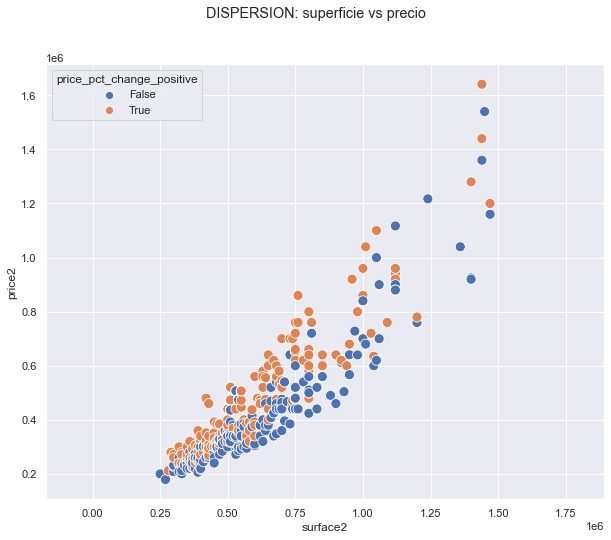

In [130]:
fig = plt.figure(figsize=(10,8))
fig.suptitle('DISPERSION: superficie vs precio')
ax = plt.axes()

la_plata['surface2'] = la_plata.surface_total_in_m2*10000
la_plata['price2'] = la_plata.price*4
#ax.set(xlim=(20,90), ylim=(25000,200000))
g = sns.scatterplot(x='surface2', y='price2', data=la_plata, hue='price_pct_change_positive', s=100)

g.axis("equal")

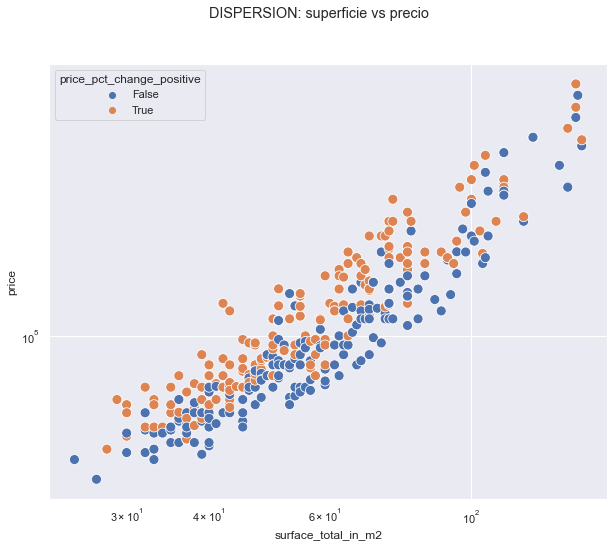

In [139]:
fig = plt.figure(figsize=(10,8))
fig.suptitle('DISPERSION: superficie vs precio')
ax = plt.axes()

ax.set(xscale='log', yscale='log')
g = sns.scatterplot(x='surface_total_in_m2', y='price', data=la_plata, hue='price_pct_change_positive', s=100)

In [ ]:
# tenes que volver a entrenar el modelo, 1 quitando los place_missing, y dos solo con las columnas rojas del sector izquierdo, buscalo dentro de una iteracion de los coeficientes! 